# Import Libraries

In [1]:
import os
import zipfile
import warnings
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Activation, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflowjs as tfjs


import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Load Dataset From Kaggle

In [2]:
!kaggle datasets download utkarshsaxenadn/car-vs-bike-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset
License(s): CC0-1.0
car-vs-bike-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
zip_file_path = 'car-vs-bike-classification-dataset.zip'
extract_dir = 'car-vs-bike'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [4]:
bike_dir = './car-vs-bike/Car-Bike-Dataset/Bike'
car_dir = './car-vs-bike/Car-Bike-Dataset/Car'

Bike Class Images


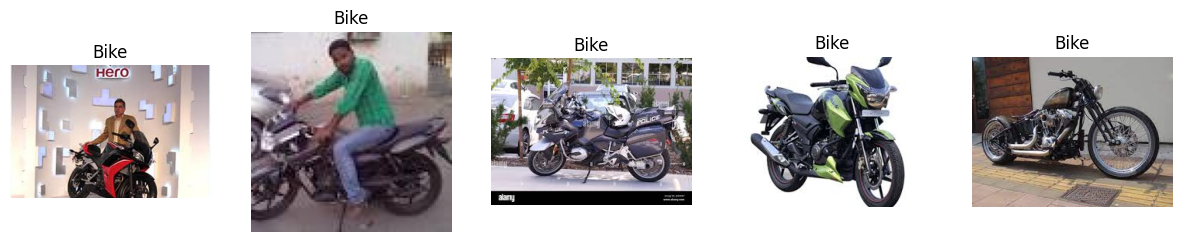

Car Class Images


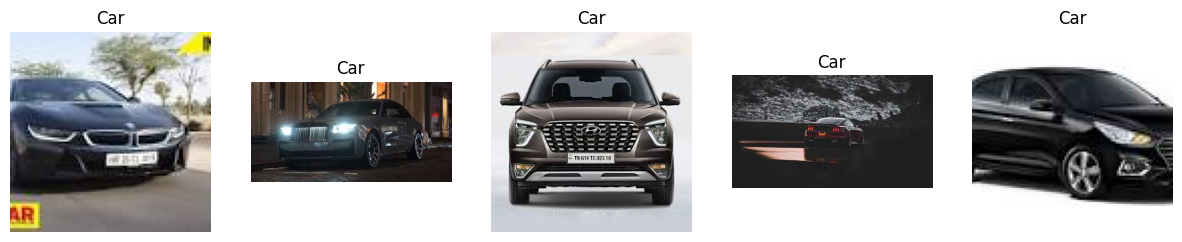

In [5]:
def display_random_images(directory, class_name, num_images=5):
    images = random.sample(os.listdir(directory), num_images)
    plt.figure(figsize=(15, 5))
    
    for i, img_name in enumerate(images):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
    
    plt.show()

# Display 5 random images for each class
print("Bike Class Images")
display_random_images(bike_dir, 'Bike')

print("Car Class Images")
display_random_images(car_dir, 'Car')

In [6]:
X = [] 
Z = []  
IMG_SIZE = 150 

def assigned_label(img, car_or_bike):
    return car_or_bike

def train_dataset(car_or_bike, DIR):
    for img in tqdm(os.listdir(DIR)):
        label = assigned_label(img, car_or_bike)
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [7]:
train_dataset('Bike', bike_dir)
train_dataset('Car', car_dir)

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1437.65it/s]


# Data Augmentation

In [8]:
datagen = ImageDataGenerator(
    rotation_range=10,      
    zoom_range=0.1,          
    width_shift_range=0.2,   
    height_shift_range=0.2,
    horizontal_flip=True
)
X = np.array(X)
X = X / 255 
Z = np.array(Z)

datagen.fit(X)

# Encode and Split Data

In [9]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, 2) 

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Model Training - CNN

In [10]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(150,150,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))


model.add(Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,713,282 (40.87 MB)

 Trainable params: 10,712,834 (40.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
class StopTrainingAtAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        val_accuracy = logs.get("val_accuracy")
        
        if accuracy is not None and val_accuracy is not None:
            if accuracy >= 0.93 and val_accuracy >= 0.93:
                print(f"\nTraining stopped as accuracy and val_accuracy both reached 93% or higher on epoch {epoch + 1}")
                self.model.stop_training = True

# Inisialisasi callback
stop_callback = StopTrainingAtAccuracy()

In [13]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[stop_callback]
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 607ms/step - accuracy: 0.6714 - loss: 1.4618 - val_accuracy: 0.5275 - val_loss: 4.7582
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 651ms/step - accuracy: 0.8070 - loss: 0.4305 - val_accuracy: 0.5275 - val_loss: 5.2552
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 659ms/step - accuracy: 0.8593 - loss: 0.3226 - val_accuracy: 0.5275 - val_loss: 5.0329
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 684ms/step - accuracy: 0.8901 - loss: 0.2606 - val_accuracy: 0.6313 - val_loss: 2.7173
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 699ms/step - accuracy: 0.9082 - loss: 0.2159 - val_accuracy: 0.7887 - val_loss: 1.2313
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 753ms/step - accuracy: 0.9326 - loss: 0.1712 - val_accuracy: 0.8838 - val_loss: 0.5212
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 724ms/step - accuracy: 0.9342 - loss: 0.1528 - val_accuracy: 0.8950 - val_loss: 0.4022
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 751ms/step - accuracy: 0.9510 - loss: 0

# Plot Accuracy

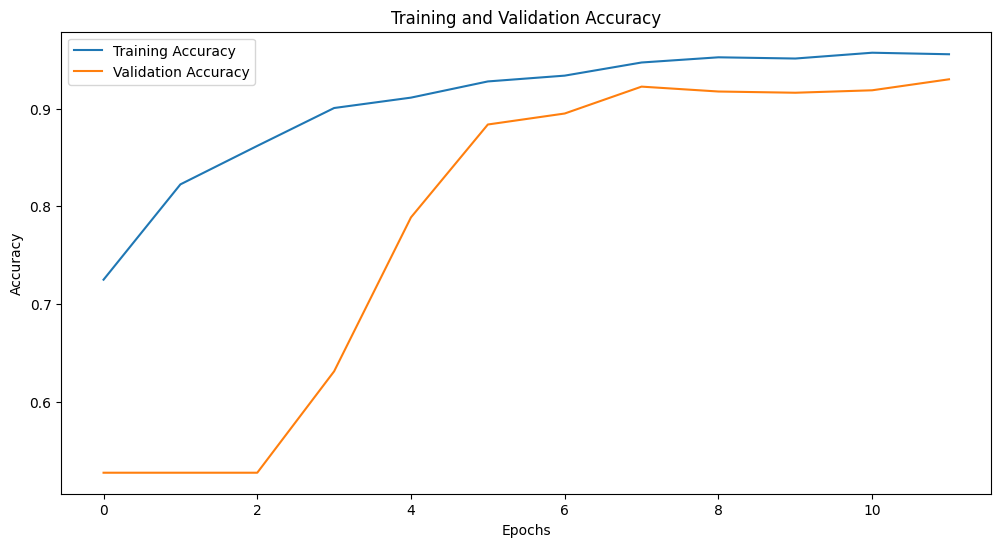

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss 

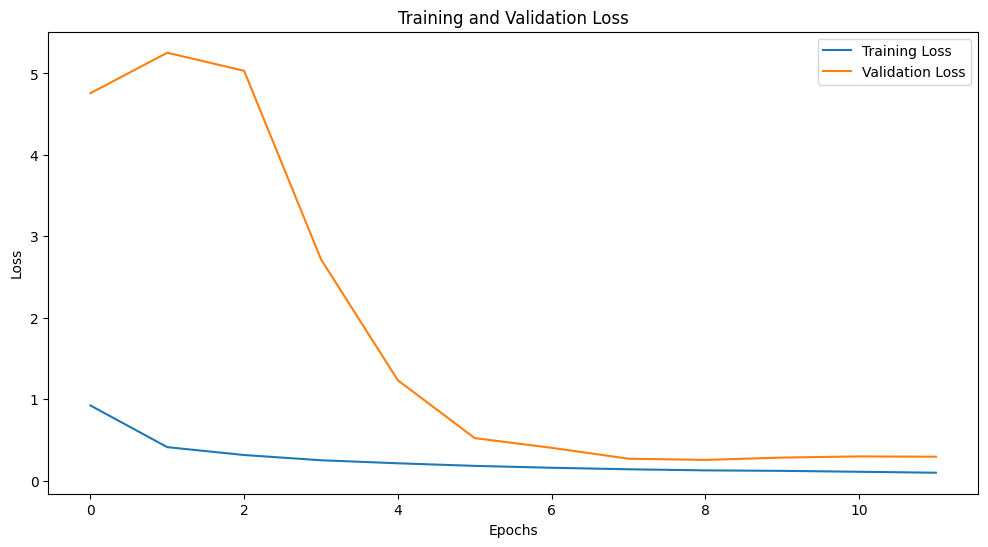

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()